Imports

In [1]:
from pathlib import Path
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize, QuantileTransformer, PowerTransformer
import statsmodels.api as sm
from statsmodels.stats.diagnostic import kstest_fit, kstest_normal


# Prepare raw data

Load raw data

In [2]:
path_data = Path('data/trials_BriefAC-v2.csv')
df_trials = pd.read_csv(path_data)
df_trials

,subID,keyYes,trialNr,picID,Context,Action,Compatibility,PT,ProbeType,Probe,CorrectResponse,Response,RT
0,1,right,3,389,workshop,hammering,compatible,83.379460,context,workshop,39,37.0,1221.324084
1,1,right,4,315,office,hammering,incompatible,50.027676,action,hammering,39,39.0,1014.310144
2,1,right,5,324,office,sawing,incompatible,50.027676,action,stamping,37,37.0,921.251088
3,1,right,6,341,office,hole-punching,compatible,33.351784,context,workshop,37,37.0,687.957941
4,1,right,7,267,kitchen,hole-punching,incompatible,50.027676,action,hole-punching,39,39.0,690.105241
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16411,19,right,869,352,office,hammering,incompatible,66.692720,context,workshop,37,37.0,515.805876
16412,19,right,870,343,office,stamping,compatible,150.058620,context,office,39,39.0,529.010548
16413,19,right,871,424,workshop,hammering,compatible,33.346360,context,kitchen,37,37.0,569.718286
16414,19,right,872,227,kitchen,whisking,compatible,50.019540,context,workshop,37,37.0,551.021686


Polishing

In [3]:
# Replace keyYes with it's keyboard counterpart
def convertKey(x):
    if x == 'left':
        x = 37
    elif x == 'right':
        x = 39
    return x

def context2scene(x):
    if x == 'context':
        x = 'Scene'
    elif x == 'action':
        x = 'Action'
    return x

df_trials.keyYes = df_trials.keyYes.apply(convertKey)

# Replace empty responses to 0-s
df_trials.Response = df_trials.Response.apply(lambda x: 0 if pd.isna(x) else x)

# Replace empty responses to 0-s
df_trials.ProbeType = df_trials.ProbeType.apply(context2scene)

# Round PT to integer
df_trials = df_trials.round({'PT' : 0, 'RT': 1})

# Convert 'PT' and 'Response' columns to integers
df_trials = df_trials.astype({'PT': 'int', 'Response': 'int'})

df_trials#.head()

,subID,keyYes,trialNr,picID,Context,Action,Compatibility,PT,ProbeType,Probe,CorrectResponse,Response,RT
0,1,39,3,389,workshop,hammering,compatible,83,Scene,workshop,39,37,1221.3
1,1,39,4,315,office,hammering,incompatible,50,Action,hammering,39,39,1014.3
2,1,39,5,324,office,sawing,incompatible,50,Action,stamping,37,37,921.3
3,1,39,6,341,office,hole-punching,compatible,33,Scene,workshop,37,37,688.0
4,1,39,7,267,kitchen,hole-punching,incompatible,50,Action,hole-punching,39,39,690.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16411,19,39,869,352,office,hammering,incompatible,67,Scene,workshop,37,37,515.8
16412,19,39,870,343,office,stamping,compatible,150,Scene,office,39,39,529.0
16413,19,39,871,424,workshop,hammering,compatible,33,Scene,kitchen,37,37,569.7
16414,19,39,872,227,kitchen,whisking,compatible,50,Scene,workshop,37,37,551.0


# Outlier exclusion (Reaction-Time-based)

### Wilcox method (just for visualization)
* Per subject & condition
* Remove upper and lower 10% of trials based on RT

Backup trials with 10% longest and shortest RT

In [4]:
df_trials.sort_values(by=['subID', 'PT', 'ProbeType', 'Compatibility', 'RT'])

l_drop_short = []
l_drop_long = []
for sub in np.unique(df_trials.subID):
    for pt in np.unique(df_trials.PT):
        for ptype in np.unique(df_trials.ProbeType):
            for comp in np.unique(df_trials.Compatibility):
                part = df_trials[
                    (df_trials.subID == sub) &
                    (df_trials.PT == pt) &
                    (df_trials.ProbeType == ptype) &
                    (df_trials.Compatibility == comp)
                    ]
                # Get top and bottom 10%
                l_drop_short.extend(
                    part.nsmallest(part.shape[0]//10, 'RT', keep='all').index.to_list())
                l_drop_long.extend(
                    part.nlargest(part.shape[0]//10, 'RT', keep='all').index.to_list())

In [5]:
df_trials_short = df_trials.take(l_drop_short)
df_trials_long = df_trials.take(l_drop_long)

In [6]:
df_trials_short.head()

,subID,keyYes,trialNr,picID,Context,Action,Compatibility,PT,ProbeType,Probe,CorrectResponse,Response,RT
838,1,39,848,226,kitchen,grating,compatible,33,Action,grating,39,37,406.0
222,1,39,227,306,office,hole-punching,compatible,33,Action,hole-punching,39,37,408.4
283,1,39,288,258,kitchen,cutting,compatible,33,Action,grating,37,37,439.5
322,1,39,327,416,workshop,stamping,incompatible,33,Action,sawing,37,37,361.0
674,1,39,683,318,office,hammering,incompatible,33,Action,stamping,37,37,403.3


In [7]:
df_trials_long.head()

,subID,keyYes,trialNr,picID,Context,Action,Compatibility,PT,ProbeType,Probe,CorrectResponse,Response,RT
165,1,39,169,223,kitchen,grating,compatible,33,Action,grating,39,39,1643.7
125,1,39,129,314,office,stapling,compatible,33,Action,stapling,39,37,1444.2
76,1,39,79,347,office,stapling,compatible,33,Action,hole-punching,37,37,1337.9
47,1,39,50,302,office,whisking,incompatible,33,Action,whisking,39,37,1719.5
77,1,39,80,245,kitchen,hammering,incompatible,33,Action,grating,37,37,1603.1


### 2sd left and right of the RT distribution

Within:
* subject
* PT
* Probe Type
* Compatibility

Transformation

In [8]:
def symmetrize(x):
    """
    Transform RT (x) to achieve a symmetrical shape for the RT distribution:
    y_i = sqrt( (x_i - min(x)) / (max(x) - min(x)) )
    
    Berger & Kiefer (2021)
    """
    return np.sqrt( (x - x.agg('min')) / (x.agg('max') - x.agg('min')) )

Add column with "symmetrized" RTs and z-transform it

In [9]:
df_trials['transRT'] = df_trials.groupby(
    ['subID', 'PT', 'ProbeType', 'Compatibility'],
    group_keys=False).RT.apply(symmetrize)

df_trials['zRT'] = df_trials.groupby(
    ['subID', 'PT', 'ProbeType', 'Compatibility']).transRT.transform(stats.zscore)

df_trials

,subID,keyYes,trialNr,picID,Context,Action,Compatibility,PT,ProbeType,Probe,CorrectResponse,Response,RT,transRT,zRT
0,1,39,3,389,workshop,hammering,compatible,83,Scene,workshop,39,37,1221.3,0.693395,0.959455
1,1,39,4,315,office,hammering,incompatible,50,Action,hammering,39,39,1014.3,0.867728,1.171207
2,1,39,5,324,office,sawing,incompatible,50,Action,stamping,37,37,921.3,0.799823,0.815164
3,1,39,6,341,office,hole-punching,compatible,33,Scene,workshop,37,37,688.0,0.591583,0.025715
4,1,39,7,267,kitchen,hole-punching,incompatible,50,Action,hole-punching,39,39,690.1,0.598509,-0.240382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16411,19,39,869,352,office,hammering,incompatible,67,Scene,workshop,37,37,515.8,0.237654,-1.602235
16412,19,39,870,343,office,stamping,compatible,150,Scene,office,39,39,529.0,0.376836,-1.204653
16413,19,39,871,424,workshop,hammering,compatible,33,Scene,kitchen,37,37,569.7,0.368303,-1.064725
16414,19,39,872,227,kitchen,whisking,compatible,50,Scene,workshop,37,37,551.0,0.246326,-1.098294


Get +- 2SD tails

In [10]:
df_trials_left2sd = df_trials.loc[df_trials.zRT < -2]
df_trials_right2sd = df_trials.loc[df_trials.zRT > 2]

df_trials_left2sd.to_csv('data/outliers-rt_2sd_left.csv')
df_trials_right2sd.to_csv('data/outliers-rt_2sd_right.csv')

In [11]:
df_trials_left2sd.head()

,subID,keyYes,trialNr,picID,Context,Action,Compatibility,PT,ProbeType,Probe,CorrectResponse,Response,RT,transRT,zRT
150,1,39,154,337,office,whisking,incompatible,67,Action,whisking,39,37,416.8,0.0,-3.550419
158,1,39,162,222,kitchen,cutting,compatible,117,Scene,kitchen,39,39,535.7,0.0,-2.466658
225,1,39,230,376,workshop,hole-punching,incompatible,117,Action,hole-punching,39,39,475.0,0.0,-2.832523
227,1,39,232,417,workshop,stamping,incompatible,83,Action,stamping,39,37,489.8,0.0,-2.972751
249,1,39,254,223,kitchen,grating,compatible,150,Scene,kitchen,39,37,527.1,0.0,-2.594100


In [12]:
df_trials_right2sd.head()

,subID,keyYes,trialNr,picID,Context,Action,Compatibility,PT,ProbeType,Probe,CorrectResponse,Response,RT,transRT,zRT
6,1,39,9,261,kitchen,grating,compatible,50,Scene,workshop,37,37,1630.7,1.0,2.947753
7,1,39,10,242,kitchen,stapling,incompatible,50,Scene,office,37,39,1977.9,1.0,2.651138
16,1,39,19,318,office,hammering,incompatible,67,Scene,workshop,37,39,1376.7,1.0,2.150877
36,1,39,39,339,office,hole-punching,compatible,150,Scene,office,39,39,1350.2,1.0,2.883032
40,1,39,43,388,workshop,hammering,compatible,83,Action,hammering,39,39,1595.4,1.0,2.500972


Quantify dropped (left and right; per condition)

In [13]:
l_outliers = []
l_right = []
for pt in np.unique(df_trials.PT):
    for ptype in np.unique(df_trials.ProbeType):
        for comp in np.unique(df_trials.Compatibility):
            n_ = df_trials[
                    (df_trials.PT == pt) &
                    (df_trials.ProbeType == ptype) &
                    (df_trials.Compatibility == comp)].shape[0]
            left = df_trials[
                    (df_trials.PT == pt) &
                    (df_trials.ProbeType == ptype) &
                    (df_trials.Compatibility == comp) &
                    (df_trials.zRT < -2)]
            
            right = df_trials[
                    (df_trials.PT == pt) &
                    (df_trials.ProbeType == ptype) &
                    (df_trials.Compatibility == comp) &
                    (df_trials.zRT > 2)]
            
            l_outliers.append([pt, ptype, comp,
                               np.round(left.shape[0]/n_, 3),
                               np.round(right.shape[0]/n_, 3)])
            
pd.DataFrame(l_outliers,
             columns=['PT', 'ProbeType', 'Compatibility', 'OutLeft', 'OutRight'])

,PT,ProbeType,Compatibility,OutLeft,OutRight
0,33,Action,compatible,0.031,0.026
1,33,Action,incompatible,0.026,0.016
2,33,Scene,compatible,0.031,0.020
3,33,Scene,incompatible,0.028,0.013
4,50,Action,compatible,0.026,0.016
5,50,Action,incompatible,0.034,0.018
6,50,Scene,compatible,0.025,0.034
7,50,Scene,incompatible,0.025,0.031
8,67,Action,compatible,0.028,0.019
9,67,Action,incompatible,0.023,0.016


Drop

In [14]:
df_trials.drop(
    df_trials[(df_trials.zRT < -2) & (df_trials.zRT < -2)].index,
    inplace=True)

df_trials

,subID,keyYes,trialNr,picID,Context,Action,Compatibility,PT,ProbeType,Probe,CorrectResponse,Response,RT,transRT,zRT
0,1,39,3,389,workshop,hammering,compatible,83,Scene,workshop,39,37,1221.3,0.693395,0.959455
1,1,39,4,315,office,hammering,incompatible,50,Action,hammering,39,39,1014.3,0.867728,1.171207
2,1,39,5,324,office,sawing,incompatible,50,Action,stamping,37,37,921.3,0.799823,0.815164
3,1,39,6,341,office,hole-punching,compatible,33,Scene,workshop,37,37,688.0,0.591583,0.025715
4,1,39,7,267,kitchen,hole-punching,incompatible,50,Action,hole-punching,39,39,690.1,0.598509,-0.240382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16411,19,39,869,352,office,hammering,incompatible,67,Scene,workshop,37,37,515.8,0.237654,-1.602235
16412,19,39,870,343,office,stamping,compatible,150,Scene,office,39,39,529.0,0.376836,-1.204653
16413,19,39,871,424,workshop,hammering,compatible,33,Scene,kitchen,37,37,569.7,0.368303,-1.064725
16414,19,39,872,227,kitchen,whisking,compatible,50,Scene,workshop,37,37,551.0,0.246326,-1.098294


In [32]:
df_trials.to_csv('data/trials_BriefAC-v2_rt-cleaned.csv')

# Performance extraction

### Accuracy

In [34]:
def accuracy(y_pred, y_true):
    """Computes sensitivity (d-prime index) as defined in MacMillan & Creelman (2005)"""
    #score = y_pred = subset.Response
    #y_true = subset.CorrectResponse
    return accuracy_score(y_true, y_pred)

In [35]:
a_subs = np.unique(df_trials.subID)
a_pts  = np.unique(df_trials.PT)
a_comp = np.unique(df_trials.Compatibility)
a_prob = np.unique(df_trials.Probe)

l_data = []

# iterate over subjects ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for i in range(len(a_subs)):
    n_samples = 0
    n_empty = 0
    hits = 0
    misses = 0
    corr_rejections = 0
    f_alarms = 0

    # iterate over PTs ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    for j in range(len(a_pts)):
        #print(a_subs[i], a_pts[j])
        # iterate over Compatibility ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        for k in range(len(a_comp)):
            #print(a_subs[i], a_pts[j], a_comp[k])
            # iterate over Probe ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            for l in range(len(a_prob)):
                subset = df_trials[
                            (df_trials.subID == a_subs[i]) &
                            (df_trials.PT == a_pts[j]) &
                            (df_trials.Compatibility == a_comp[k]) &
                            (df_trials.Probe == a_prob[l])]
                score = accuracy(subset.Response, subset.CorrectResponse)
                
                if len(np.unique(subset.ProbeType)) == 1:
                    ptype = np.unique(subset.ProbeType)[0]
                else:
                    raise Exception('More than one ProbeType found!')
                l_data.append([a_subs[i], a_pts[j], a_comp[k],
                               ptype, a_prob[l],score])

In [37]:
df_accuracy = pd.DataFrame(l_data,
                          columns=['subID', 'PT', 'Compatibility', 'ProbeType',
                                   'Probe', 'Accuracy'])

df_accuracy

,subID,PT,Compatibility,ProbeType,Probe,Accuracy
0,1,33,compatible,Action,cutting,0.600000
1,1,33,compatible,Action,grating,1.000000
2,1,33,compatible,Action,hammering,0.500000
3,1,33,compatible,Action,hole-punching,0.600000
4,1,33,compatible,Scene,kitchen,0.500000
...,...,...,...,...,...,...
2731,19,150,incompatible,Action,sawing,0.750000
2732,19,150,incompatible,Action,stamping,1.000000
2733,19,150,incompatible,Action,stapling,0.500000
2734,19,150,incompatible,Action,whisking,1.000000


In [38]:
df_accuracy.to_csv('data/accuracy_rt-cleaned.csv')

## Sensitivity (d-prime)

Function to extract task performance

In [15]:
def summary(df):
    """Given a set of trials, extract summary data:
    * Hit : Yes when "yes" is correct
    * False Alarm : Yes when "no" is correct
    * Correct Rejection : No when "no" is correct
    * Miss : No when "yes" is correct
    """
    n_hits = 0;
    n_misses = 0;
    n_correjections = 0;
    n_falarms = 0;
    n_empty = 0;
    
    # Iterate over trials (rows of subset)
    for index, row in df.iterrows():
        # Ignore empty
        if row.Response == 0:
            n_empty += 1
            continue
        
        # YES-responses
        if row.Response == row.keyYes:
            if row.Response == row.CorrectResponse:
                n_hits += 1
            else:
                n_falarms += 1
        # NO-responses
        else:
            if row.Response == row.CorrectResponse:
                n_correjections += 1
            else:
                n_misses += 1
    
    #print(n_empty)
    
    return (n_hits, n_falarms, n_correjections, n_misses)

Function to compute d-prime from performance measures

In [16]:
def dprime(n_hits, n_falarms, n_correjections, n_misses):
    """Computes sensitivity (d-prime index) as defined in MacMillan & Creelman (2005)"""
    # Compute H- & F-rates
    if n_hits == 0: # H = 0
        H = 1 / (2*(n_hits + n_misses))
    elif n_misses == 0: # H = 1
        H = 1 - 1 / (2*(n_hits + n_misses))
    else:
        H = n_hits / (n_hits + n_misses)
        
    if n_falarms == 0: # F = 0
        F = 1 / (2*(n_falarms + n_correjections))
    elif n_correjections == 0: # F = 1
        F = 1 - 1 / (2*(n_falarms + n_correjections))
    else:
        F = n_falarms / (n_falarms + n_correjections)
    
    d = norm.ppf(H) - norm.ppf(F)
    
    # Compute perfect score (max d-prime) w/ assumptions:
    # = Hits: 1 - 1/(2N) = 1 - 1/[2*(Hits + Misses)];
    # = FalseAlarms: 1/2N = 1/2*(FalseAlarms + CorrectRejections)
    H_ideal = 1 - 1 / (2*(n_hits + n_misses))
    F_ideal = 1 / (2*(n_falarms + n_correjections))
    d_ideal = norm.ppf(H_ideal) - norm.ppf(F_ideal)
    
    return d

Extract performance summary

In [17]:
a_subs = np.unique(df_trials.subID)
a_pts  = np.unique(df_trials.PT)
a_comp = np.unique(df_trials.Compatibility)
a_prob = np.unique(df_trials.ProbeType)

l_data = []

# iterate over subjects ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for i in range(len(a_subs)):
    #print(i)
    n_samples = 0;
    n_empty = 0;
    hits = 0;
    misses = 0;
    corr_rejections = 0;
    f_alarms = 0;

    # iterate over PTs ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    for j in range(len(a_pts)):
        #print(a_subs[i], a_pts[j])
        # iterate over Compatibility ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        for k in range(len(a_comp)):
            #print(a_subs[i], a_pts[j], a_comp[k])
            # iterate over ProbeType ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            for l in range(len(a_prob)):
                subset = df_trials[
                            (df_trials.subID == a_subs[i]) &
                            (df_trials.PT == a_pts[j]) &
                            (df_trials.Compatibility == a_comp[k]) &
                            (df_trials.ProbeType == a_prob[l])]
                (n_hits, n_falarms, n_correjections, n_misses) = summary(subset)
                d = dprime(n_hits, n_falarms, n_correjections, n_misses)
                
                l_data.append([a_subs[i], a_pts[j], a_comp[k], a_prob[l],
                               n_hits, n_falarms, n_correjections, n_misses, d])
                #print(a_subs[i], a_pts[j], a_comp[k], a_prob[l], subset.shape)

Save to dataframe

In [18]:
df_summary = pd.DataFrame(l_data,
                          columns=['subID', 'PT', 'Compatibility', 'ProbeType',
                                   'n_hits', 'n_falarms', 'n_correjections',
                                   'n_misses', 'dprime'])

df_summary
#df_summary.to_csv('data/summary_data_rt-cleaned.csv')

,subID,PT,Compatibility,ProbeType,n_hits,n_falarms,n_correjections,n_misses,dprime
0,1,33,compatible,Action,2,0,18,15,0.727674
1,1,33,compatible,Scene,5,3,14,13,0.339444
2,1,33,incompatible,Action,3,1,17,14,0.664319
3,1,33,incompatible,Scene,2,3,13,16,-0.333494
4,1,50,compatible,Action,4,7,10,14,-0.541702
...,...,...,...,...,...,...,...,...,...
451,19,117,incompatible,Scene,11,1,17,6,1.970611
452,19,150,compatible,Action,15,7,11,3,1.249638
453,19,150,compatible,Scene,17,1,17,0,3.482729
454,19,150,incompatible,Action,12,3,15,5,1.508817


### Normality check & transformation

Q-Q plot

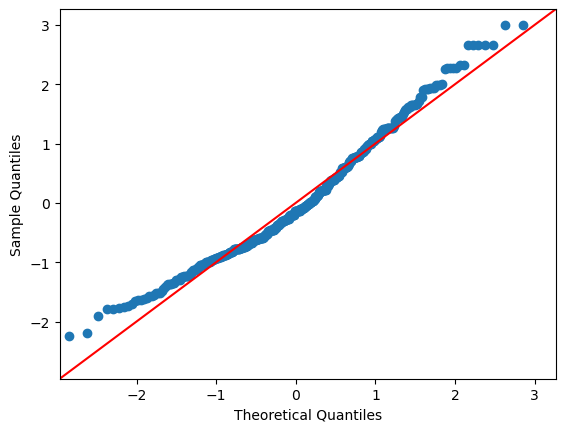

In [19]:
data = sm.datasets.longley.load()
fig = sm.qqplot(df_summary.dprime.to_numpy(),
                fit=True, line="45")
plt.show()

Kolmogorov-Smirnov test

In [20]:
(ksstat, pvalue) = kstest_normal(df_summary.dprime.to_numpy(), dist='norm')

print((ksstat, pvalue))

(0.076746243671443, 0.0009999999999998899)


Transform using **Quantile Transformer**

This however introduces very high ("outlying") values (dprime ~5)

In [21]:
def transform_qt(X):
    X_t = QuantileTransformer(
            output_distribution="normal").fit_transform(X.reshape(-1, 1))
    #print(X_t)
    return X_t.squeeze()

(0.02095077632065312, 0.9288015266547871)


/home/ov/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (456). n_quantiles is set to n_samples.
  warnings.warn(


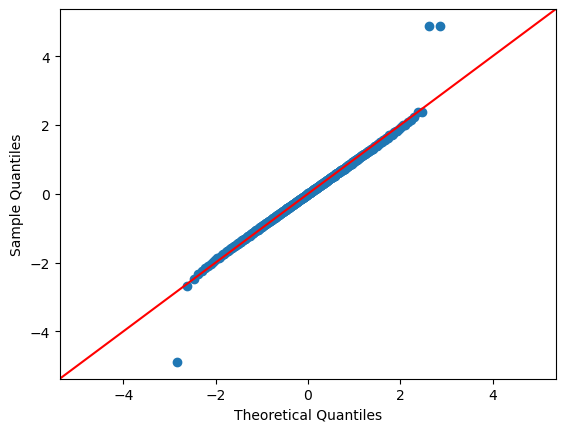

In [22]:
X = df_summary.dprime.to_numpy().reshape(-1, 1)
X_normed_qt = QuantileTransformer(output_distribution="normal").fit_transform(X).squeeze()
X_normed_nm = normalize(X, norm='max', axis=0).squeeze()

(ksstat, pvalue) = kstest_normal(X_normed_qt, dist='norm')
print((ksstat, pvalue))

fig = sm.qqplot(X_normed_qt,
                fit=True, line="45")
plt.show()

Yeo-Johnson

In [23]:
def transform_pt(X):
    X_t = PowerTransformer(method="yeo-johnson", standardize=False).fit_transform(X.reshape(-1, 1))
    return X_t.squeeze()

(0.03340342649945227, 0.29632446355377934)


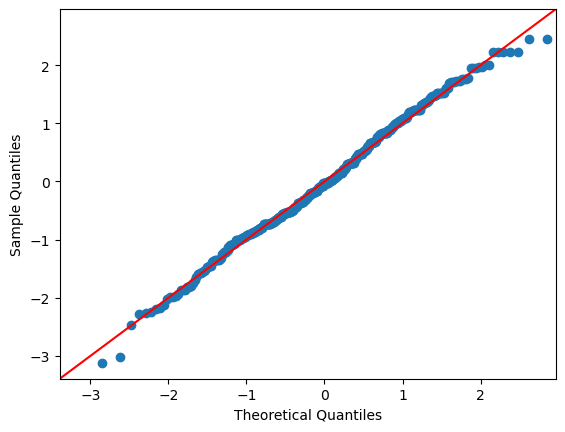

In [24]:
yj = PowerTransformer(method="yeo-johnson")

X_normed_yj = yj.fit_transform(X).squeeze()

(ksstat, pvalue) = kstest_normal(X_normed_yj, dist='norm')
print((ksstat, pvalue))

fig = sm.qqplot(X_normed_yj,
                fit=True, line="45")
plt.show()

### Export for ANOVA
One column - one factor level \
One row - one subject

In [25]:
keys = []
for sub in np.unique(df_trials.subID):
    #print(sub, np.unique(df_trials[df_trials.subID == sub].keyYes)[0])
    keys.append(np.unique(df_trials[df_trials.subID == sub].keyYes)[0])

# Pivot
df_pivoted = df_summary.pivot(index='subID',
                              columns=['ProbeType', 'Compatibility', 'PT'],
                              values=['dprime'])
# Sort columns
df_pivoted = df_pivoted.sort_index(axis=1)
# Shorten column names
df_pivoted.columns = [''.join(str(col[1:])).strip()
                      .replace('\'', '')
                      .replace('Action', 'Act')
                      .replace('Scene', 'Scn')
                      .replace('incompatible', 'I')
                      .replace('compatible', 'C')
                      for col in df_pivoted.columns.values]
# Insert 'keyYes' column
df_pivoted.insert(0, 'keyYes', keys)
df_pivoted

,keyYes,"(Act, C, 33)","(Act, C, 50)","(Act, C, 67)","(Act, C, 83)","(Act, C, 117)","(Act, C, 150)","(Act, I, 33)","(Act, I, 50)","(Act, I, 67)",...,"(Scn, C, 67)","(Scn, C, 83)","(Scn, C, 117)","(Scn, C, 150)","(Scn, I, 33)","(Scn, I, 50)","(Scn, I, 67)","(Scn, I, 83)","(Scn, I, 117)","(Scn, I, 150)"
subID,,,,,,,,,,,,,,,,,,,,,
1,39,0.727674,-0.541702,0.065919,0.110668,0.972122,1.688944,0.664319,1.041213,0.223315,...,1.377951,2.171726,2.149540,2.785367,-0.333494,0.259179,0.237682,0.401685,0.366448,0.110668
2,37,1.103393,0.297691,0.517102,0.387318,1.667010,1.306105,0.223315,0.442869,0.551508,...,1.995454,2.107787,1.762035,3.482729,-0.028492,-0.223315,0.387504,0.809439,-0.207719,-0.401685
3,39,0.615186,1.003738,1.518355,0.303601,2.154182,1.617559,0.132066,0.017600,1.142102,...,0.972122,2.154253,1.942163,2.522118,0.377392,0.307240,0.073791,0.966848,0.401685,0.270816
4,37,0.893630,1.262917,1.688944,1.130851,1.518355,2.522118,0.679245,1.294432,2.023946,...,1.942163,2.455901,2.780050,3.479232,0.814200,1.152250,1.896321,2.522118,1.508817,1.776287
5,39,-0.213502,1.068610,0.838501,0.646683,1.211116,1.518355,-0.157311,0.208425,0.808119,...,3.157945,3.479232,3.804016,3.157945,-0.505224,0.653735,-0.083519,0.083298,0.729166,-0.132066
6,37,0.843204,0.963824,0.259179,0.095176,0.581812,0.154384,-0.291741,0.164190,-0.132066,...,-0.349779,1.373111,1.124800,0.947084,0.000000,0.344086,0.344086,0.668870,0.499118,-0.372578
7,39,-0.223008,0.223008,1.211116,0.756104,1.310978,2.441281,0.073791,0.154384,0.154384,...,1.693609,1.688944,2.843405,3.101337,0.628487,0.721522,0.628487,0.541702,2.117771,1.508817
8,37,0.377966,1.047121,0.663247,1.130851,0.808119,1.895130,0.275933,1.051824,1.150349,...,1.749800,2.123576,1.875435,2.843405,1.373111,0.597376,0.590030,0.110668,0.043187,-0.756104
9,39,0.406387,1.537114,0.756104,0.498172,1.564726,1.282510,0.679245,0.207377,0.498172,...,0.024996,0.296291,0.024996,0.024996,-0.541702,0.947084,-0.296291,0.000000,-0.024996,0.296291


In [26]:
df_pivoted.to_csv('data/dprime_BriefAC-v2_rt-cleaned.csv')

Transform using Yeh-Johnson

In [27]:
df_pivoted_normed = df_pivoted.copy(deep=True)
df_pivoted_normed.iloc[:, 1:] = df_pivoted_normed.iloc[:, 1:].apply(transform_pt, axis=1, raw=True)

df_pivoted_normed

,keyYes,"(Act, C, 33)","(Act, C, 50)","(Act, C, 67)","(Act, C, 83)","(Act, C, 117)","(Act, C, 150)","(Act, I, 33)","(Act, I, 50)","(Act, I, 67)",...,"(Scn, C, 67)","(Scn, C, 83)","(Scn, C, 117)","(Scn, C, 150)","(Scn, I, 33)","(Scn, I, 50)","(Scn, I, 67)","(Scn, I, 83)","(Scn, I, 117)","(Scn, I, 150)"
subID,,,,,,,,,,,,,,,,,,,,,
1,39,0.596382,-0.637590,0.064480,0.106706,0.756733,1.159487,0.552303,0.799558,0.208062,...,0.995129,1.390499,1.380434,1.651552,-0.370484,0.238981,0.220522,0.356177,0.327989,0.106706
2,37,0.884947,0.276679,0.458988,0.353036,1.236707,1.016779,0.211105,0.399020,0.486239,...,1.423144,1.484331,1.291874,2.152469,-0.028712,-0.236467,0.353192,0.680820,-0.219123,-0.443268
3,39,0.490835,0.719107,0.966474,0.268587,1.215538,1.008831,0.124798,0.017462,0.790795,...,0.702101,1.215563,1.137969,1.339615,0.325243,0.271448,0.071443,0.699240,0.343296,0.242482
4,37,0.809068,1.108900,1.437926,1.003403,1.308107,2.041491,0.627368,1.133811,1.686246,...,1.626382,1.995141,2.219721,2.686329,0.742469,1.020621,1.592619,2.041491,1.300775,1.503481
5,39,-0.231162,0.786425,0.650386,0.526338,0.864809,1.021149,-0.166933,0.193203,0.631439,...,1.666040,1.767801,1.864994,1.666040,-0.602395,0.531095,-0.086245,0.080698,0.581002,-0.138860
6,37,0.892365,1.026673,0.264427,0.095913,0.606438,0.156295,-0.285332,0.166346,-0.130680,...,-0.340736,1.492349,1.208064,1.007949,0.000000,0.353154,0.353154,0.700851,0.517557,-0.362391
7,39,-0.242278,0.205698,0.864611,0.598314,0.917179,1.414060,0.071739,0.145788,0.145788,...,1.103393,1.101252,1.559622,1.646789,0.513919,0.575934,0.513919,0.453504,1.286898,1.016256
8,37,0.370259,0.997330,0.641331,1.073842,0.776755,1.756976,0.271695,1.001637,1.091606,...,1.628976,1.956613,1.739677,2.574631,1.293204,0.579284,0.572345,0.109948,0.043075,-0.785286
9,39,0.398473,1.450001,0.731162,0.486585,1.474923,1.218756,0.658722,0.205186,0.486585,...,0.024962,0.291943,0.024962,0.024962,-0.555689,0.909696,-0.300725,0.000000,-0.025030,0.291943


In [28]:
df_pivoted_normed.to_csv('data/dprime_BriefAC-v2_rt-cleaned_yj-normed.csv')

## Reaction Time

### Export for ANOVA
One column - one factor level \
One row - one subject

In [29]:
# Compute mean RT within subject and rest of factors
df_rt_summary = df_trials[
    df_trials.CorrectResponse == df_trials.Response].groupby(
        ['subID', 'ProbeType', 'Compatibility', 'PT']).mean('RT').drop(
            columns=['keyYes', 'trialNr', 'picID', 'CorrectResponse', 'Response']
            )

# Reset index (flatten) and pivot        
df_rt_pivoted = df_rt_summary.reset_index(
    level=[0,1,2, 3]).pivot(
        index='subID',
        columns=['ProbeType', 'Compatibility', 'PT'],
        values=['RT'])

# Sort columns
df_rt_pivoted = df_rt_pivoted.sort_index(axis=1)

# Rename columns
df_rt_pivoted.columns = [
    ''.join(str(col[1:])).strip()
    .replace('\'', '')
    .replace('Action', 'Act')
    .replace('Scene', 'Scn')
    .replace('incompatible', 'I')
    .replace('compatible', 'C') 
    for col in df_rt_pivoted.columns.values]

# Insert "keyYes" column
df_rt_pivoted.insert(0, 'keyYes', keys)

df_rt_pivoted

,keyYes,"(Act, C, 33)","(Act, C, 50)","(Act, C, 67)","(Act, C, 83)","(Act, C, 117)","(Act, C, 150)","(Act, I, 33)","(Act, I, 50)","(Act, I, 67)",...,"(Scn, C, 67)","(Scn, C, 83)","(Scn, C, 117)","(Scn, C, 150)","(Scn, I, 33)","(Scn, I, 50)","(Scn, I, 67)","(Scn, I, 83)","(Scn, I, 117)","(Scn, I, 150)"
subID,,,,,,,,,,,,,,,,,,,,,
1,39,770.560000,795.350000,795.833333,802.666667,784.512500,907.360714,792.825000,777.966667,828.668421,...,844.260000,835.828571,822.096667,746.140625,629.546667,841.026316,751.747368,811.945000,797.495000,842.450000
2,37,831.233333,790.422222,829.638095,827.125000,718.826923,806.650000,883.963158,789.515789,748.050000,...,699.814286,800.793103,656.371429,661.473529,787.588235,718.131250,697.694737,572.942857,752.131250,622.353333
3,39,907.914286,727.283333,745.518519,743.947368,798.865517,787.492593,823.294444,679.817647,814.328000,...,651.591667,728.236667,660.275862,710.490323,784.120000,737.450000,748.600000,633.212500,669.490000,729.657895
4,37,1042.308696,807.928000,878.975000,980.840000,808.792593,924.667742,859.947619,1042.432000,854.296552,...,855.303448,779.580000,805.987500,732.970588,1106.263636,837.680000,816.131034,763.245161,791.522222,919.460714
5,39,1012.306250,775.529167,858.613043,715.204762,737.956000,771.755556,840.775000,954.710526,719.795652,...,665.875758,664.379412,594.348571,620.884848,887.142857,929.372727,818.543750,699.727778,897.321739,903.864706
6,37,880.835000,1228.300000,989.821053,1027.383333,1044.233333,1040.411111,1000.462500,1012.905556,860.670588,...,688.275000,825.630435,741.357143,855.785714,850.923529,868.633333,793.711111,844.231579,773.615000,724.900000
7,39,864.981250,780.957895,774.828000,896.942857,812.419231,801.890625,836.900000,880.655556,802.377778,...,728.521429,698.767857,761.184375,700.151515,795.385714,673.968182,746.080952,750.480952,825.765517,797.003704
8,37,719.615000,829.730435,943.086364,874.496000,768.326087,835.075000,825.252632,962.304545,836.052174,...,834.884000,777.475000,798.871429,753.368750,786.682609,791.850000,765.695238,818.994444,833.150000,806.564286
9,39,736.605263,800.454167,760.747619,705.785000,711.176000,589.621739,830.038095,733.188889,675.095000,...,642.894444,653.250000,684.527778,648.966667,733.785714,833.628571,706.258824,697.411111,703.141176,723.150000


### Export to csv

In [30]:
df_rt_pivoted.to_csv('data/rt_BriefAC-v2_rt-cleaned.csv')